In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import scipy.stats as stats
import scipy.ndimage
import altair as alt
from pyemd import emd, emd_samples

%config InlineBackend.figure_format = 'retina'

First, load the dataset.

In [3]:
size = 100000
raw = pd.read_csv('flights-10m.csv', nrows=size)

In [4]:
raw.head(10)

,FlightDate,DepTime,DepDelay,ArrTime,ArrDelay,AirTime,Distance
0,2006-01-01,905.0,5.0,1229.0,19.0,350.0,2475.0
1,2006-01-02,1147.0,167.0,1546.0,216.0,343.0,2475.0
2,2006-01-03,853.0,-7.0,1208.0,-2.0,344.0,2475.0
3,2006-01-04,855.0,-5.0,1157.0,-13.0,331.0,2475.0
4,2006-01-05,857.0,-3.0,1153.0,-17.0,321.0,2475.0
5,2006-01-06,856.0,-4.0,1138.0,-32.0,320.0,2475.0
6,2006-01-08,857.0,-3.0,1208.0,-2.0,346.0,2475.0
7,2006-01-09,903.0,3.0,1210.0,0.0,334.0,2475.0
8,2006-01-10,853.0,-7.0,1149.0,-21.0,334.0,2475.0
9,2006-01-11,908.0,8.0,1200.0,-10.0,321.0,2475.0


Below, change the configuration for the fields we want to look at.

In [5]:
active = "AirTime"
passive = "ArrDelay"
active_range = [0, 500]
passive_range = [-20, 50]

pixels = 500
bins = 25

In [6]:
df = raw[
    (active_range[0] <= raw[active]) & (raw[active] < active_range[1]) &
    (passive_range[0] <= raw[passive]) & (raw[passive] < passive_range[1])]

## Compute count matrix

Now, compute the count matrix for the active and passive dimensions. For this, aggregate into a binned matrix. 

In [7]:
bins_active = np.linspace(active_range[0], active_range[1], pixels + 1)
bins_passive = np.linspace(passive_range[0], passive_range[1], bins + 1)

hist, xedges, yedges = np.histogram2d(df[active], df[passive], bins=(bins_active, bins_passive))

In [8]:
# add 0s as the first row

pdf = np.vstack([np.zeros(bins), hist])

<BarContainer object of 25 artists>

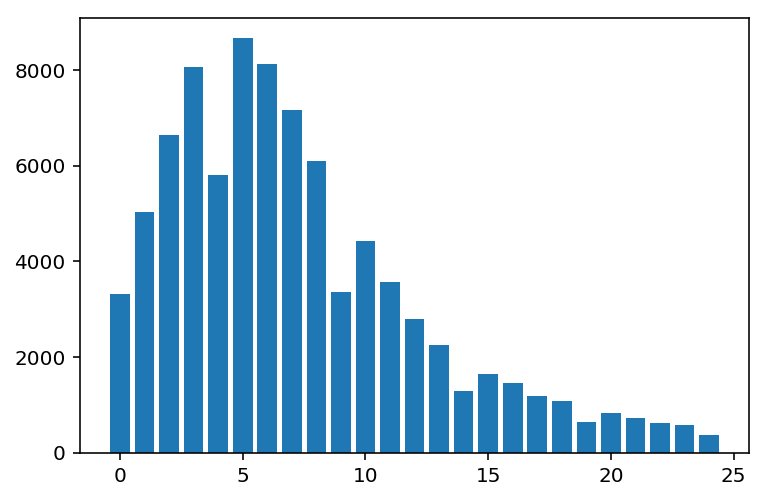

In [9]:
# compute unfiltered histogram and render it

unfiltered, edges = np.histogram(df[passive], bins=bins_passive)
plt.bar(np.arange(len(unfiltered)), unfiltered)

In [10]:
def show(a, size=(6,6)):
    """ Helper function to show a matrix. """
    print("Shape:", a.shape)
    plt.figure(figsize=size)
    plt.imshow(a, aspect='auto')
    plt.colorbar()

Let's look at the PDF of the count matrix. 

Shape: (501, 25)


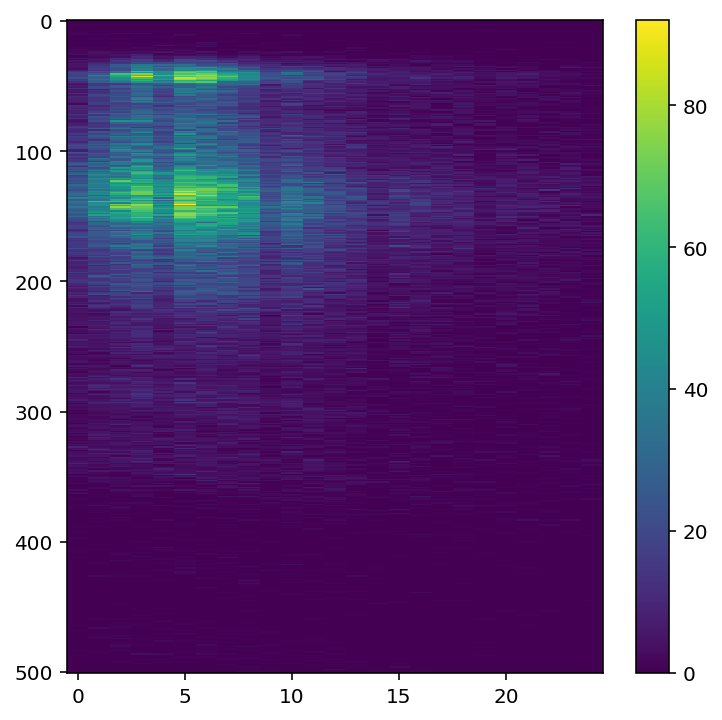

In [11]:
show(pdf)

Shape: (25, 501)


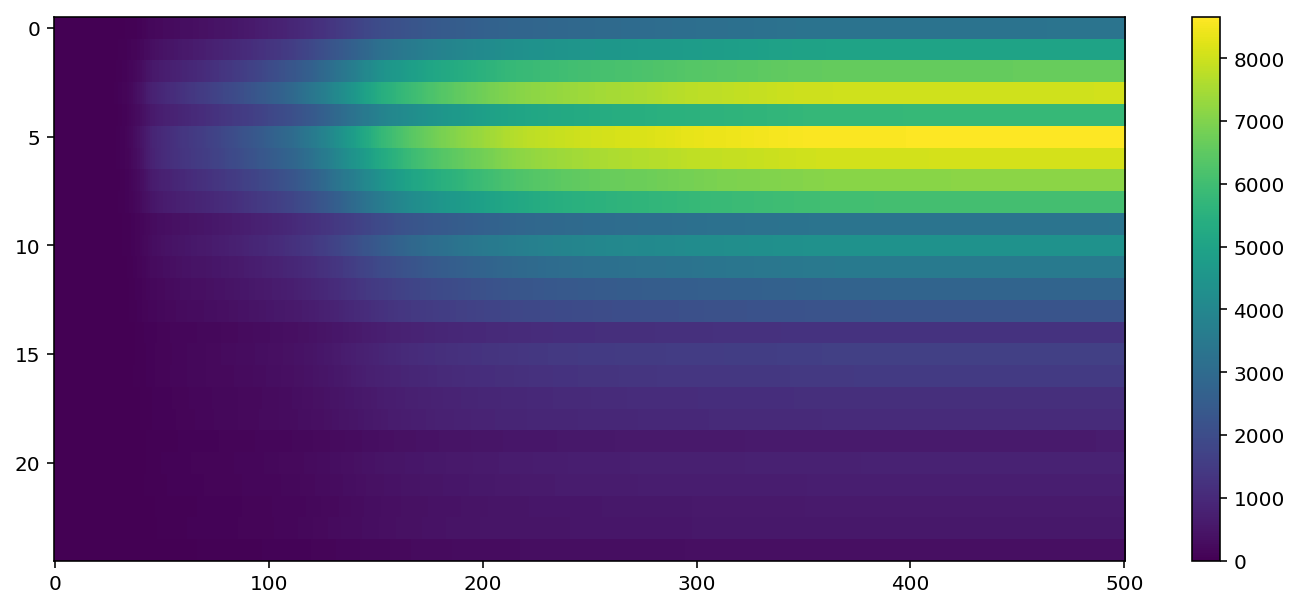

In [59]:
# used to make the data tile figure in the paper
show(np.cumsum(pdf, axis=0).T, (12, 5))

## Compute cumulative count matrix

Now, compute a cumulative count matrix. The cumulative version is computed along the active dimension. 

In [13]:
cdf = np.cumsum(pdf, axis=0)

Shape: (501, 25)


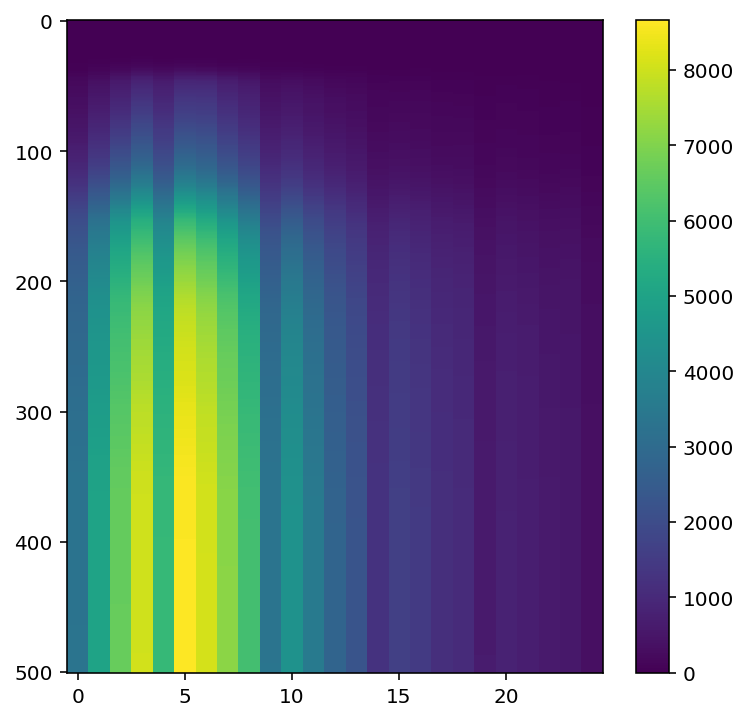

In [14]:
show(cdf)

## Interpolation from low resolution

Okay, now that we have a cumulative count matrix, we could compute the conditional histograms from this. However, the count matrix is a bit large. Let's see how well we could do the same from a lower resolution version. 

To do this, we first create a low resolution cdf where we pick every k rows. Then we use simple linear interpolation along the columns to get back something as close as possible to the original cumulative count matrix. 

Width 20.0
Row indexes [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500]
Shape: (26, 25)


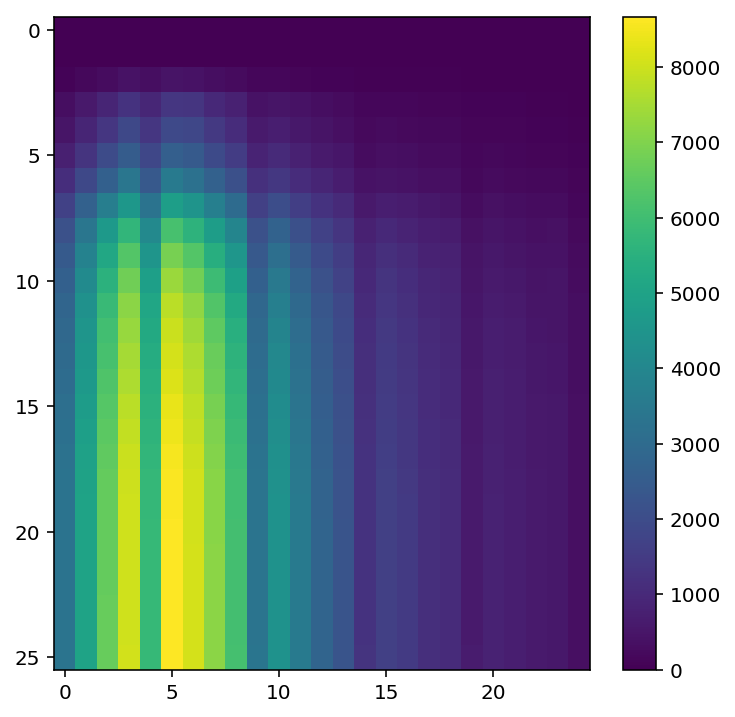

In [15]:
print("Width", pixels/bins)
idx = list(range(0,pixels+1, int(pixels/bins)))
print("Row indexes", idx)
low_res = cdf[idx, :]
show(low_res)

In [16]:
# compute the interpolated cdf as the same dimensions as the high resolution cdf

# i = interpolate.interp1d(np.arange(pixels), cdf, kind="linear", axis=0)
p = np.arange(0, pixels+1, pixels/bins);
print("Value locations: ", p)
i = interpolate.interp1d(p, low_res, kind="linear", axis=0)

to_interpolate = np.arange(0, pixels+1)
interpolated_cdf = i(to_interpolate)

assert interpolated_cdf.shape == cdf.shape, f"Interpolated matrix does not have the right dimensions {interpolated_cdf.shape} != {cdf.shape}"

Value locations:  [  0.  20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.
 280. 300. 320. 340. 360. 380. 400. 420. 440. 460. 480. 500.]


Shape: (501, 25)


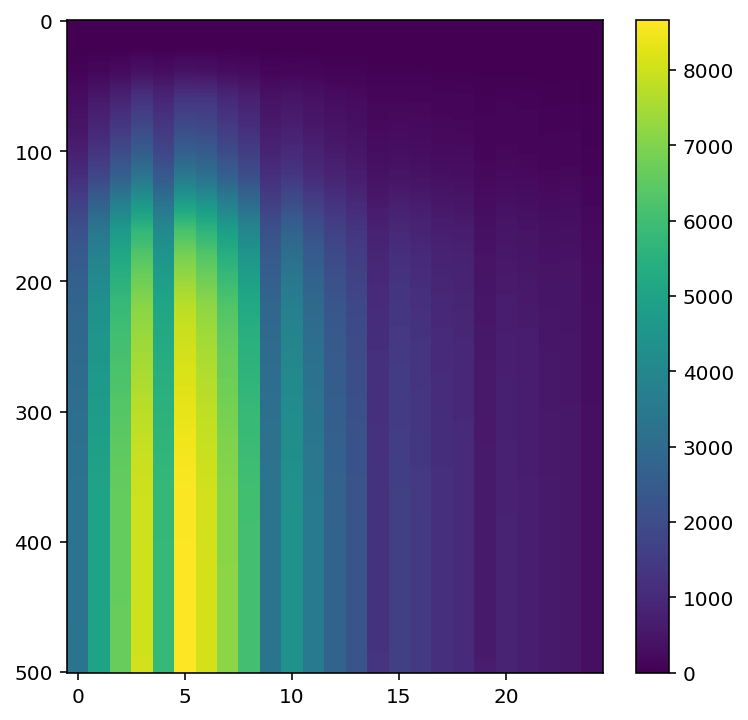

In [17]:
show(interpolated_cdf)

This looks pretty good but how close is it actually to the original cumulative count matrix?

## Evaluation

First, let's visualize the difference betwen the interpolation and the true CDF. 

Shape: (501, 25)


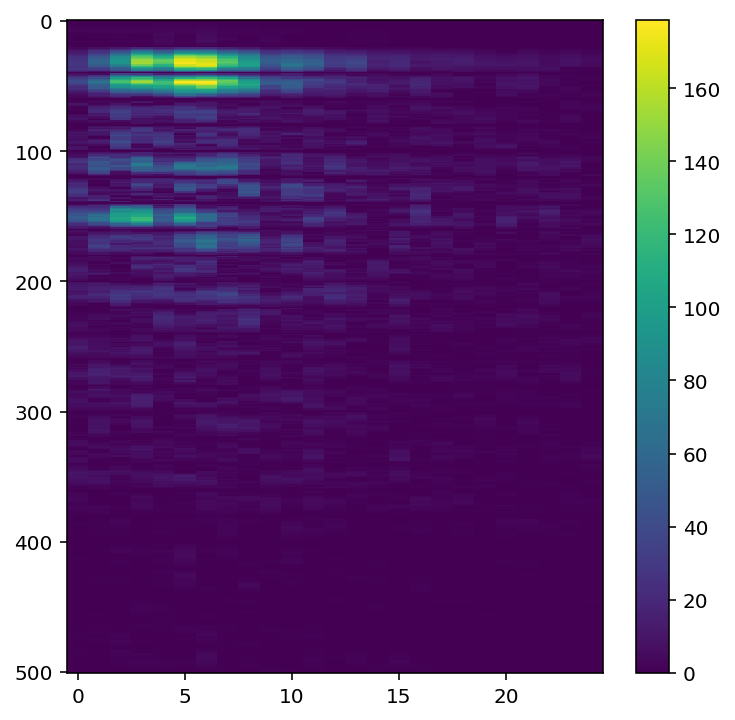

In [18]:
show(np.abs(cdf - interpolated_cdf))

In [67]:
data = []

min_brush = int(pixels / bins)

print("Minimum brush size:", min_brush)

for size in range(min_brush, pixels, 20):
    for start in range(pixels - size):
        end = start + size
        
        hist_a = interpolated_cdf[end] - interpolated_cdf[start]
        hist_b = cdf[end] - cdf[start]
        
        # scaling factor to scale to unfiltered data
        factor = hist_b.max() / unfiltered.max()
#         factor = 1
        
        d = stats.wasserstein_distance(np.arange(bins)/(bins-1), np.arange(bins)/(bins-1), hist_a, hist_b) * factor
        
        sumdiff = hist_a.sum() - hist_b.sum()
        
        data.append([start, size, d, hist_a.sum(), hist_b.sum(), sumdiff])
        
distances = pd.DataFrame(data, columns=["start", "size", "distance", "sum_a", "sum_b", "sumdiff"])

Minimum brush size: 20


In [68]:
print(distances.shape)
distances.head()

(6000, 6)


,start,size,distance,sum_a,sum_b,sumdiff
0,0,20,0.000000,74.00,74.0,0.00
1,1,20,0.000035,252.25,84.0,168.25
2,2,20,0.000051,430.50,99.0,331.50
3,3,20,0.000053,608.75,115.0,493.75
4,4,20,0.000062,787.00,154.0,633.00


### Find the item with the worst error

Here we look for the brushes with the highest distance between the interpolated and the true histogram.

In [69]:
worst = distances.loc[distances.distance.idxmax()]
print(worst)

start          47.000000
size          220.000000
distance        0.000903
sum_a       72803.050000
sum_b       71437.000000
sumdiff      1366.050000
Name: 3947, dtype: float64


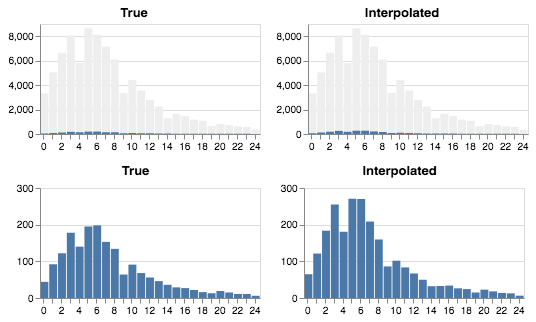

In [70]:
start = int(worst.start)
end = int(worst.start + worst.size)

hists = pd.DataFrame(data={
    'count': cdf[end] - cdf[start],
    'interpolated': interpolated_cdf[end] - interpolated_cdf[start],
    'unfiltered': unfiltered,
    'bins': np.arange(len(unfiltered))
})

base = alt.Chart(hists).mark_bar().encode(
    x=alt.X("bins:O", title=None, axis=alt.Axis(labelAngle=0))
).properties(width=220, height=110)

alt.vconcat(base.properties(title="True").encode(
    y=alt.Y("unfiltered:Q", title=None),
    color=alt.ValueDef("#eee")
) + base.encode(
    y=alt.Y("count:Q", title=None),
) | base.properties(title="Interpolated").encode(
    y=alt.Y("unfiltered:Q", title=None),
    color=alt.ValueDef("#eee")
) + base.encode(
    y=alt.Y("interpolated:Q", title=None),
), base.properties(title="True").encode(
    y=alt.Y("count:Q", title=None, scale=alt.Scale(domain=[0,300])),
) | base.properties(title="Interpolated").encode(
    y=alt.Y("interpolated:Q", title=None, scale=alt.Scale(domain=[0,300])),
))

### Error overview

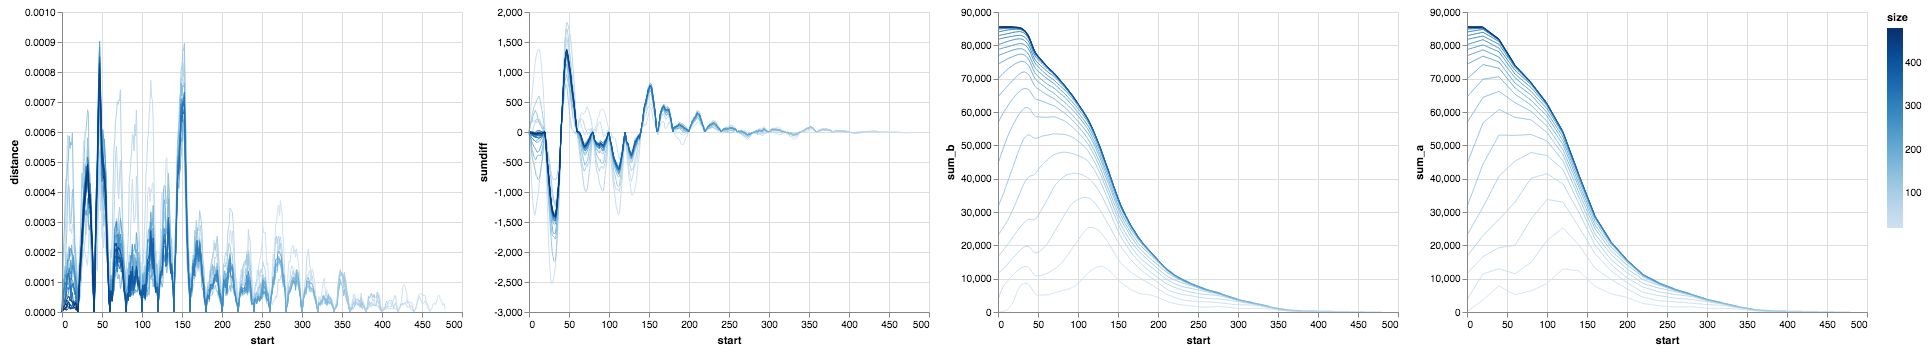

In [71]:
alt.data_transformers.enable('default', max_rows=1000000)

filtered_distances = distances[distances.sum_b > size * 0.05]

alt.Chart(distances).mark_line(strokeWidth=1).encode(
    x="start:Q",
    y="distance:Q",
    color="size:Q"
) | alt.Chart(distances).mark_line(strokeWidth=1).encode(
    x="start:Q",
    y="sumdiff:Q",
    color="size:Q"
) | alt.Chart(distances).mark_line(strokeWidth=1).encode(
    x="start:Q",
    y="sum_b:Q",
    color="size:Q"
) | alt.Chart(distances).mark_line(strokeWidth=1).encode(
    x="start:Q",
    y="sum_a:Q",
    color="size:Q"
)